In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
# Bước 1: Đọc dữ liệu
df = pd.read_csv('data/xAPI-Edu-Data.csv')
df = df.drop(columns=['StageID','GradeID','SectionID','Semester'])
print(df.isnull().sum())

gender                      0
NationalITy                 0
PlaceofBirth                0
Topic                       0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64


In [4]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['NationalITy'] = le.fit_transform(df['NationalITy'])
df['PlaceofBirth'] = le.fit_transform(df['PlaceofBirth'])
df['Topic'] = le.fit_transform(df['Topic'])
df['Relation'] = le.fit_transform(df['Relation'])
df['ParentAnsweringSurvey'] = le.fit_transform(df['ParentAnsweringSurvey'])
df['ParentschoolSatisfaction'] = le.fit_transform(df['ParentschoolSatisfaction'])
df['StudentAbsenceDays'] = le.fit_transform(df['StudentAbsenceDays'])
df['Class'] = df['Class'].map({'L': 0, 'M': 1, 'H': 2})

# Chuẩn hóa các giá trị số
scaler = StandardScaler()
numeric_columns = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# In dữ liệu đã chuẩn hóa
print(df.head())


   gender  NationalITy  PlaceofBirth  Topic  Relation  raisedhands  \
0       1            4             4      7         0    -1.033429   
1       1            4             4      7         0    -0.870813   
2       1            4             4      7         0    -1.196046   
3       1            4             4      7         0    -0.545579   
4       1            4             4      7         0    -0.220346   

   VisITedResources  AnnouncementsView  Discussion  ParentAnsweringSurvey  \
0         -1.174075          -1.351167   -0.843326                      1   
1         -1.053029          -1.313549   -0.662225                      1   
2         -1.446426          -1.426401   -0.481125                      0   
3         -0.901723          -1.238315   -0.300024                      0   
4         -0.145191          -0.974994    0.243279                      0   

   ParentschoolSatisfaction  StudentAbsenceDays  Class  
0                         1                   1      1  
1 

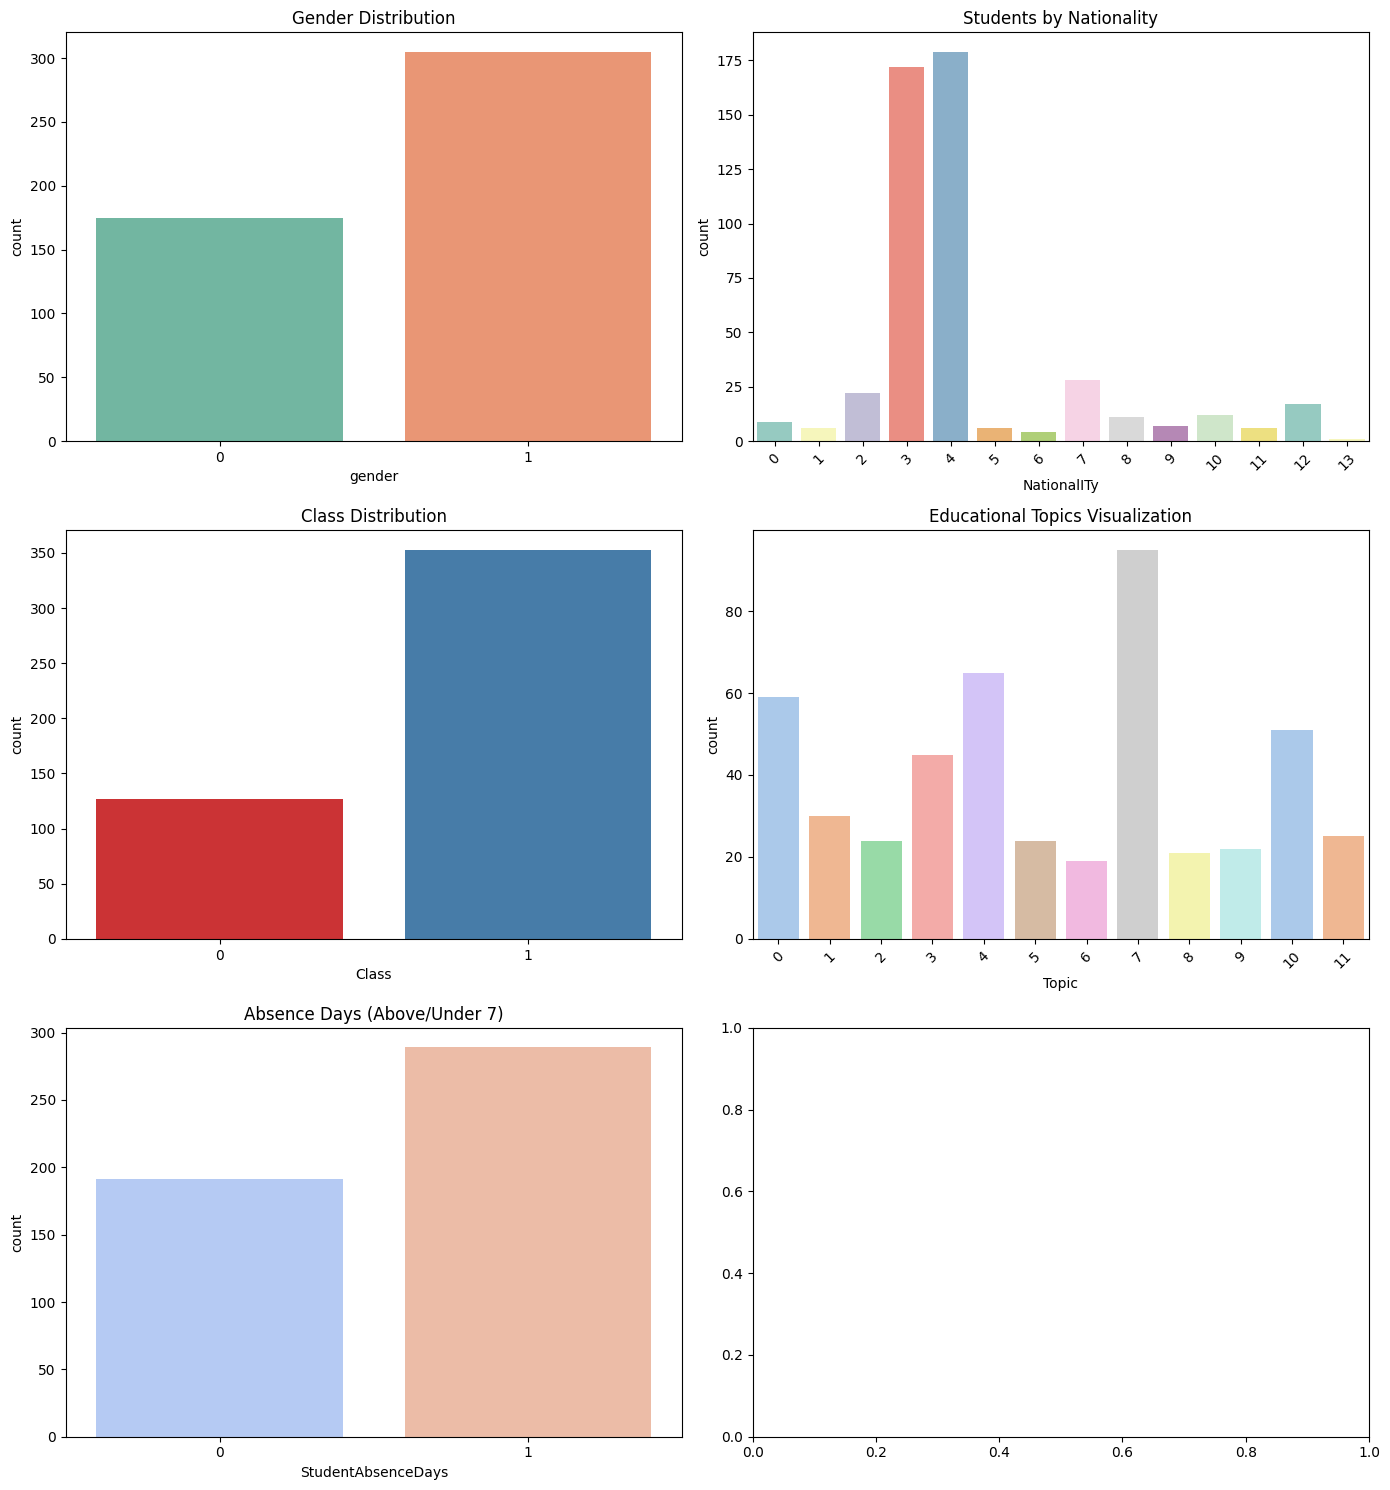

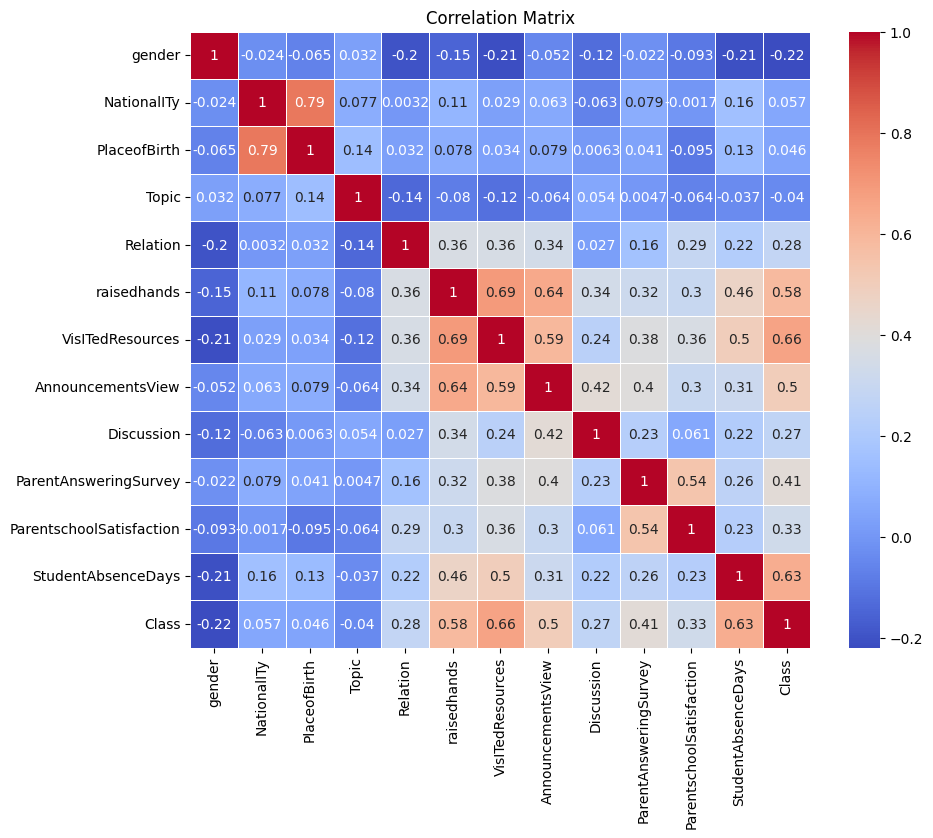

In [3]:
# Tạo Figure và Subplot
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Biểu đồ Giới tính
sns.countplot(ax=axes[0, 0], x='gender', hue='gender', data=df, palette='Set2', legend=False)
axes[0, 0].set_title('Gender Distribution')

# Biểu đồ Quốc gia
sns.countplot(ax=axes[0, 1], x='NationalITy', hue='NationalITy', data=df, palette='Set3', legend=False)
axes[0, 1].set_title('Students by Nationality')
axes[0, 1].tick_params(axis='x', rotation=45)

# Biểu đồ Class
sns.countplot(ax=axes[1, 0], x='Class', hue='Class', data=df, palette='Set1', legend=False)
axes[1, 0].set_title('Class Distribution')

# Biểu đồ Chủ đề môn học
sns.countplot(ax=axes[1, 1], x='Topic', hue='Topic', data=df, palette='pastel', legend=False)
axes[1, 1].set_title('Educational Topics Visualization')
axes[1, 1].tick_params(axis='x', rotation=45)

# Biểu đồ Số ngày nghỉ
sns.countplot(ax=axes[2, 0], x='StudentAbsenceDays', hue='StudentAbsenceDays', data=df, palette='coolwarm', legend=False)
axes[2, 0].set_title('Absence Days (Above/Under 7)')

# Căn chỉnh khoảng cách
plt.tight_layout()
plt.show()

correlation_matrix = df.corr()

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [5]:
# Bước 6: Tách X (features) và y (label)
X = df.drop('Class', axis=1)
y = df['Class']

# Chia train-test với stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Grid tham số cho ANN
ann_param_grid = [
    {
        'hidden_layer_sizes': [(50,), (100,), (150,)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.001, 0.01]
    },
    {
        'hidden_layer_sizes': [(50, 50), (100, 50), (150, 75)],
        'solver': ['adam', 'sgd'],
        'learning_rate_init': [0.001, 0.01]
    },
    {
        'hidden_layer_sizes': [(100,), (200,), (300,)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.001, 0.01]
    }
]

ann_results = []

for n_features in range(9, 13):
    rfe_selector = RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=n_features)
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    # Lặp qua các bộ tham số ANN
    ann_model = MLPClassifier(random_state=42,max_iter=1000)
    for grid in ann_param_grid:
        ann_grid = GridSearchCV(estimator=ann_model, param_grid=grid, cv=10, scoring='accuracy', n_jobs=-1)
        ann_grid.fit(X_train_rfe, y_train)
        ann_best = ann_grid.best_estimator_
        ann_accuracy = accuracy_score(y_test, ann_best.predict(X_test_rfe))
        ann_results.append({
            'n_features': n_features,
            'best_params': ann_grid.best_params_,
            'accuracy': ann_accuracy
        })
        print(f"[ANN] n_features={n_features} | accuracy={ann_accuracy:.4f} | params={ann_grid.best_params_}")

# Xuất kết quả ra file CSV
pd.DataFrame(ann_results).to_csv('data/ann_dt_rfe_results.csv', index=False)


In [ ]:
# Grid tham số cho ANN
ann_param_grid = [
    {
        'hidden_layer_sizes': [(50,), (100,), (150,)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.001, 0.01]
    },
    {
        'hidden_layer_sizes': [(50, 50), (100, 50), (150, 75)],
        'solver': ['adam', 'sgd'],
        'learning_rate_init': [0.001, 0.01]
    },
    {
        'hidden_layer_sizes': [(100,), (200,), (300,)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.001, 0.01]
    }
]

ann_results = []

for n_features in range(9, 13):
    rfe_selector = RFE(estimator=SVC(kernel='linear', random_state=42), n_features_to_select=n_features)
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    # Lặp qua các bộ tham số ANN
    ann_model = MLPClassifier(random_state=42)
    for grid in ann_param_grid:
        ann_grid = GridSearchCV(estimator=ann_model, param_grid=grid, cv=10, scoring='accuracy', n_jobs=-1)
        ann_grid.fit(X_train_rfe, y_train)
        ann_best = ann_grid.best_estimator_
        ann_accuracy = accuracy_score(y_test, ann_best.predict(X_test_rfe))
        ann_results.append({
            'n_features': n_features,
            'best_params': ann_grid.best_params_,
            'accuracy': ann_accuracy
        })
        print(f"[ANN] n_features={n_features} | accuracy={ann_accuracy:.4f} | params={ann_grid.best_params_}")

# Xuất kết quả ra file CSV
pd.DataFrame(ann_results).to_csv('data/ann_svm_rfe_results.csv', index=False)


In [ ]:
# Grid tham số cho SVM
svm_param_grid = [
    {
        'C': [0.5, 1, 5],
        'kernel': ['sigmoid', 'linear', 'rbf'],
        'gamma': ['scale', 0.01, 0.1]
    },
    # Bộ tham số thứ hai
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly'],
        'gamma': ['scale', 'auto']
    },
    # Bộ tham số thứ ba
    {
        'C': [0.5, 2, 3],
        'kernel': ['rbf', 'sigmoid'],
        'gamma': ['scale', 0.01]
    }
]

svm_results = []

for n_features in range(9, 13):
    rfe_selector = RFE(estimator=SVC(kernel='linear', random_state=42), n_features_to_select=n_features)
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    # Lặp qua các bộ tham số SVM
    svm_model = SVC(random_state=42)
    for grid in svm_param_grid:
        svm_grid = GridSearchCV(estimator=svm_model, param_grid=grid, cv=10, scoring='accuracy', n_jobs=-1)
        svm_grid.fit(X_train_rfe, y_train)
        svm_best = svm_grid.best_estimator_
        svm_accuracy = accuracy_score(y_test, svm_best.predict(X_test_rfe))
        svm_results.append({
            'n_features': n_features,
            'best_params': svm_grid.best_params_,
            'accuracy': svm_accuracy
        })
        print(f"[SVM] n_features={n_features} | accuracy={svm_accuracy:.4f} | params={svm_grid.best_params_}")

# Xuất kết quả ra file CSV
pd.DataFrame(svm_results).to_csv('data/svm_svm_results.csv', index=False)


[SVM] n_features=9 | accuracy=0.7917 | params={'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
[SVM] n_features=10 | accuracy=0.7396 | params={'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
[SVM] n_features=11 | accuracy=0.6875 | params={'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
[SVM] n_features=12 | accuracy=0.7604 | params={'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
# Grid tham số cho SVM
svm_param_grid = [
    {
        'C': [0.5, 1, 5],
        'kernel': ['sigmoid', 'linear', 'rbf'],
        'gamma': ['scale', 0.01, 0.1]
    },
    # Bộ tham số thứ hai
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly'],
        'gamma': ['scale', 'auto']
    },
    # Bộ tham số thứ ba
    {
        'C': [0.5, 2, 3],
        'kernel': ['rbf', 'sigmoid'],
        'gamma': ['scale', 0.01]
    }
]

svm_results = []

for n_features in range(9, 13):
    rfe_selector = RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=n_features)
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    # Lặp qua các bộ tham số SVM
    svm_model = SVC(random_state=42)
    for grid in svm_param_grid:
        svm_grid = GridSearchCV(estimator=svm_model, param_grid=grid, cv=10, scoring='accuracy', n_jobs=-1)
        svm_grid.fit(X_train_rfe, y_train)
        svm_best = svm_grid.best_estimator_
        svm_accuracy = accuracy_score(y_test, svm_best.predict(X_test_rfe))
        svm_results.append({
            'n_features': n_features,
            'best_params': svm_grid.best_params_,
            'accuracy': svm_accuracy
        })
        print(f"[SVM] n_features={n_features} | accuracy={svm_accuracy:.4f} | params={svm_grid.best_params_}")

# Xuất kết quả ra file CSV
pd.DataFrame(svm_results).to_csv('data/svm__dt_results.csv', index=False)


[SVM] n_features=9 | accuracy=0.7396 | params={'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
[SVM] n_features=10 | accuracy=0.7604 | params={'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
[SVM] n_features=11 | accuracy=0.7500 | params={'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
[SVM] n_features=12 | accuracy=0.7604 | params={'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
# Grid tham số cho Decision Tree
dt_param_grid = [
    # Bộ tham số đầu tiên
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, None],
        'min_samples_split': [2, 4, 8]
    },
    # Bộ tham số thứ hai
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 4]
    },
    # Bộ tham số thứ ba
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [7, 15, None],
        'min_samples_split': [2, 6, 10]
    }
]

dt_results = []

for n_features in range(9, 13):
    rfe_selector = RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=n_features)
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    # Lặp qua các bộ tham số Decision Tree
    dt_model = DecisionTreeClassifier(random_state=42)
    for grid in dt_param_grid:
        dt_grid = GridSearchCV(estimator=dt_model, param_grid=grid, cv=10, scoring='accuracy', n_jobs=-1)
        dt_grid.fit(X_train_rfe, y_train)
        dt_best = dt_grid.best_estimator_
        dt_accuracy = accuracy_score(y_test, dt_best.predict(X_test_rfe))
        dt_results.append({
            'n_features': n_features,
            'best_params': dt_grid.best_params_,
            'accuracy': dt_accuracy
        })
        print(f"[DecisionTree] n_features={n_features} | accuracy={dt_accuracy:.4f} | params={dt_grid.best_params_}")

# Xuất kết quả ra file CSV
pd.DataFrame(dt_results).to_csv('data/dt_dt_results.csv', index=False)


[DecisionTree] n_features=9 | accuracy=0.7500 | params={'criterion': 'gini', 'max_depth': None, 'min_samples_split': 8}
[DecisionTree] n_features=10 | accuracy=0.7708 | params={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 8}
[DecisionTree] n_features=11 | accuracy=0.7292 | params={'criterion': 'gini', 'max_depth': None, 'min_samples_split': 4}
[DecisionTree] n_features=12 | accuracy=0.7500 | params={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}


In [ ]:
# Grid tham số cho Decision Tree
dt_param_grid = [
    # Bộ tham số đầu tiên
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, None],
        'min_samples_split': [2, 4, 8]
    },
    # Bộ tham số thứ hai
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 4]
    },
    # Bộ tham số thứ ba
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [7, 15, None],
        'min_samples_split': [2, 6, 10]
    }
]

dt_results = []

for n_features in range(9, 13):
    rfe_selector = RFE(estimator=SVC(kernel='linear', random_state=42), n_features_to_select=n_features)
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    # Lặp qua các bộ tham số Decision Tree
    dt_model = DecisionTreeClassifier(random_state=42)
    for grid in dt_param_grid:
        dt_grid = GridSearchCV(estimator=dt_model, param_grid=grid, cv=10, scoring='accuracy', n_jobs=-1)
        dt_grid.fit(X_train_rfe, y_train)
        dt_best = dt_grid.best_estimator_
        dt_accuracy = accuracy_score(y_test, dt_best.predict(X_test_rfe))
        dt_results.append({
            'n_features': n_features,
            'best_params': dt_grid.best_params_,
            'accuracy': dt_accuracy
        })
        print(f"[DecisionTree] n_features={n_features} | accuracy={dt_accuracy:.4f} | params={dt_grid.best_params_}")

# Xuất kết quả ra file CSV
pd.DataFrame(dt_results).to_csv('data/dt_svm_results.csv', index=False)


[DecisionTree] n_features=9 | accuracy=0.7396 | params={'criterion': 'gini', 'max_depth': None, 'min_samples_split': 4}
[DecisionTree] n_features=10 | accuracy=0.6875 | params={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
[DecisionTree] n_features=11 | accuracy=0.7917 | params={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 8}
[DecisionTree] n_features=12 | accuracy=0.7500 | params={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}


In [ ]:
# Danh sách các không gian tham số khác nhau mà bạn muốn thử
ada_param_grid = [
    {
        'n_estimators': [150, 200, 250],
        'estimator__criterion': ['entropy'],
        'estimator__max_depth': [2, 3, 7],
        'estimator__min_samples_split': [2, 4]
    },
]

# Lưu trữ tất cả kết quả và thông tin đặc trưng đã chọn
a_results = []

# Train mô hình và thu thập kết quả
for n_features in range(9, 13):
    # RFE chọn đặc trưng
    rfe_selector = RFE(
        estimator=DecisionTreeClassifier(random_state=42),
        n_features_to_select=n_features
    )
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    adaboost_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42,
        algorithm='SAMME'
    )
    # GridSearchCV với bộ tham số hiện tại
    ada_grid = GridSearchCV(
        estimator=adaboost_model,
        param_grid=ada_param_grid,
        cv=10,
        scoring='accuracy',
        n_jobs=-1,  # Dùng hết CPU cho nhanh
    )
    ada_grid.fit(X_train_rfe, y_train)

    # Đánh giá mô hình tốt nhất trên tập kiểm tra
    best_model = ada_grid.best_estimator_
    y_pred_test = best_model.predict(X_test_rfe)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Lưu kết quả
    result = {
        'n_features': n_features,
        'best_params': ada_grid.best_params_,
        'accuracy': test_accuracy
    }
    a_results.append(result)

    # In ra kết quả sau mỗi lần train xong cho bộ tham số hiện tại
    print(f"[Done Grid] random_state={42} | n_features={n_features} | "
            f"test_accuracy={test_accuracy:.4f} | best_params={ada_grid.best_params_}")
    print("===================")

# Chuyển kết quả thành DataFrame và lưu vào file CSV
a_results_df = pd.DataFrame(a_results)
a_results_df.to_csv('data/adaboost_rfe_results.csv', index=False)


In [ ]:
# Danh sách các không gian tham số khác nhau mà bạn muốn thử
ada_param_grid = [
    # Bộ tham số đầu tiên
    {
        'n_estimators': [150, 200, 250],
        'estimator__criterion': ['entropy'],
        'estimator__max_depth': [2, 3, 7],
        'estimator__min_samples_split': [2, 4]
    },
    # Bộ tham số thứ hai
    {
        'n_estimators': [100, 150, 200],
        'estimator__criterion': ['gini', 'entropy'],
        'estimator__max_depth': [5, 10, None],
        'estimator__min_samples_split': [2, 4, 6]
    },
    # Bộ tham số thứ ba
    {
        'n_estimators': [50, 100, 150],
        'estimator__criterion': ['entropy'],
        'estimator__max_depth': [3, 5, 15],
        'estimator__min_samples_split': [4, 6, 8]
    }
]

# Lưu trữ tất cả kết quả và thông tin đặc trưng đã chọn
a_results = []

# Train mô hình và thu thập kết quả
for n_features in range(9, 13):
    # RFE chọn đặc trưng
    rfe_selector = RFE(
        estimator=SVC(kernel='linear', random_state=42),
        n_features_to_select=n_features
    )
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    adaboost_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42,
        algorithm='SAMME'
    )

    # Duyệt qua từng bộ tham số trong ada_param_grid
    for param_set in ada_param_grid:
        # GridSearchCV với bộ tham số hiện tại
        ada_grid = GridSearchCV(
            estimator=adaboost_model,
            param_grid=param_set,
            cv=10,
            scoring='accuracy',
            n_jobs=-1,  # Dùng hết CPU cho nhanh
        )
        ada_grid.fit(X_train_rfe, y_train)

        # Đánh giá mô hình tốt nhất trên tập kiểm tra
        best_model = ada_grid.best_estimator_
        y_pred_test = best_model.predict(X_test_rfe)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        # Lưu kết quả
        result = {
            'n_features': n_features,
            'best_params': ada_grid.best_params_,
            'accuracy': test_accuracy
        }
        a_results.append(result)

        # In ra kết quả sau mỗi lần train xong cho bộ tham số hiện tại
        print(f"[Done Grid] random_state={42} | n_features={n_features} | "
              f"test_accuracy={test_accuracy:.4f} | best_params={ada_grid.best_params_}")
        print("===================")

# Chuyển kết quả thành DataFrame và lưu vào file CSV
a_results_df = pd.DataFrame(a_results)
a_results_df.to_csv('data/adaboost_svm_rfe_results.csv', index=False)


[Done Grid] random_state=42 | n_features=9 | test_accuracy=0.8229 | best_params={'estimator__criterion': 'entropy', 'estimator__max_depth': 7, 'estimator__min_samples_split': 2, 'n_estimators': 150}
[Done Grid] random_state=42 | n_features=10 | test_accuracy=0.8333 | best_params={'estimator__criterion': 'gini', 'estimator__max_depth': 7, 'estimator__min_samples_split': 4, 'n_estimators': 250}
[Done Grid] random_state=42 | n_features=11 | test_accuracy=0.8229 | best_params={'estimator__criterion': 'entropy', 'estimator__max_depth': 7, 'estimator__min_samples_split': 4, 'n_estimators': 250}
[Done Grid] random_state=42 | n_features=12 | test_accuracy=0.8438 | best_params={'estimator__criterion': 'entropy', 'estimator__max_depth': 7, 'estimator__min_samples_split': 2, 'n_estimators': 250}


In [ ]:
# Danh sách các không gian tham số khác nhau mà bạn muốn thử cho RandomForest
rf_param_grid = [
    # Bộ tham số đầu tiên
    {
        'n_estimators': [50, 150, 250],
        'criterion': ['entropy', 'gini'],
        'max_depth': [None, 3, 7],
        'min_samples_split': [2, 4]
    },
    # Bộ tham số thứ hai
    {
        'n_estimators': [100, 200, 300],
        'criterion': ['entropy', 'gini'],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 3, 5]
    },
    # Bộ tham số thứ ba
    {
        'n_estimators': [75, 175, 275],
        'criterion': ['entropy'],
        'max_depth': [None, 6, 12],
        'min_samples_split': [3, 4, 6]
    }
]

# Lưu trữ tất cả kết quả
rf_results = []

# Train mô hình và thu thập kết quả
for n_features in range(9, 13):
    # RFE chọn đặc trưng
    rfe_selector = RFE(
        estimator=DecisionTreeClassifier(random_state=42),
        n_features_to_select=n_features
    )
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    # Duyệt từng bộ tham số trong rf_param_grid
    for param_set in rf_param_grid:
        rf_model = RandomForestClassifier(random_state=42)

        rf_grid = GridSearchCV(
            estimator=rf_model,
            param_grid=param_set,
            cv=10,
            scoring='accuracy',
            n_jobs=-1  # Dùng hết CPU cho nhanh
        )
        rf_grid.fit(X_train_rfe, y_train)

        # Đánh giá mô hình tốt nhất trên tập kiểm tra
        best_model = rf_grid.best_estimator_
        y_pred_test = best_model.predict(X_test_rfe)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        # Lưu kết quả
        result = {
            'n_features': n_features,
            'best_params': rf_grid.best_params_,
            'accuracy': test_accuracy
        }
        rf_results.append(result)

        # In ra kết quả ngay sau khi train xong cho bộ tham số hiện tại
        print(f"[Done Grid] random_state=42 | n_features={n_features} | "
              f"test_accuracy={test_accuracy:.4f} | best_params={rf_grid.best_params_}")
        print("===================")

# Xuất kết quả ra file CSV
rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv('data/randomforest_rfe_results.csv', index=False)


[Done Grid] random_state=42 | n_features=9 | test_accuracy=0.8438 | best_params={'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 250}
[Done Grid] random_state=42 | n_features=10 | test_accuracy=0.8021 | best_params={'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
[Done Grid] random_state=42 | n_features=11 | test_accuracy=0.8333 | best_params={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 4, 'n_estimators': 250}
[Done Grid] random_state=42 | n_features=12 | test_accuracy=0.8229 | best_params={'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 250}


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

# Danh sách các không gian tham số khác nhau mà bạn muốn thử cho RandomForest
rf_param_grid = [
    # Bộ tham số đầu tiên
    {
        'n_estimators': [50, 150, 250],
        'criterion': ['entropy', 'gini'],
        'max_depth': [None, 3, 7],
        'min_samples_split': [2, 4]
    },
    # Bộ tham số thứ hai
    {
        'n_estimators': [100, 200, 300],
        'criterion': ['entropy', 'gini'],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 3, 5]
    },
    # Bộ tham số thứ ba
    {
        'n_estimators': [75, 175, 275],
        'criterion': ['entropy'],
        'max_depth': [None, 6, 12],
        'min_samples_split': [3, 4, 6]
    }
]

# Lưu trữ tất cả kết quả
rf_results = []

# Train mô hình và thu thập kết quả
for n_features in range(9, 13):
    # RFE chọn đặc trưng
    rfe_selector = RFE(
        estimator=SVC(kernel= 'linear', random_state=42),
        n_features_to_select=n_features
    )
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)

    # Duyệt từng bộ tham số trong rf_param_grid
    for param_set in rf_param_grid:
        rf_model = RandomForestClassifier(random_state=42)

        rf_grid = GridSearchCV(
            estimator=rf_model,
            param_grid=param_set,
            cv=10,
            scoring='accuracy',
            n_jobs=-1  # Dùng hết CPU cho nhanh
        )
        rf_grid.fit(X_train_rfe, y_train)

        # Đánh giá mô hình tốt nhất trên tập kiểm tra
        best_model = rf_grid.best_estimator_
        y_pred_test = best_model.predict(X_test_rfe)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        # Lưu kết quả
        result = {
            'n_features': n_features,
            'best_params': rf_grid.best_params_,
            'accuracy': test_accuracy
        }
        rf_results.append(result)

        # In ra kết quả ngay sau khi train xong cho bộ tham số hiện tại
        print(f"[Done Grid] random_state=42 | n_features={n_features} | "
              f"test_accuracy={test_accuracy:.4f} | best_params={rf_grid.best_params_}")
        print("===================")

# Xuất kết quả ra file CSV
rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv('data/randomforest_svm_rfe_results.csv', index=False)


[Done Grid] random_state=42 | n_features=9 | test_accuracy=0.8333 | best_params={'criterion': 'gini', 'max_depth': None, 'min_samples_split': 4, 'n_estimators': 50}
[Done Grid] random_state=42 | n_features=10 | test_accuracy=0.7604 | best_params={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
[Done Grid] random_state=42 | n_features=11 | test_accuracy=0.8229 | best_params={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 250}
[Done Grid] random_state=42 | n_features=12 | test_accuracy=0.8229 | best_params={'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 250}
